### Milestone 3 - Instructions
Create a new notebook and perform each of the following tasks and answer the related questions:

- Build a simple neural networks model
- Build a DNN model
- Build a RNN model
- Summarize your findings with examples.  Explain what the manufacturer should focus on to optimize the diaper manufacturing process.
- Solicit specific feedback on your code (instructions below).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read in data

In [2]:
# assign url variable where we will pull data from
url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [3]:
# add generic feature column names
names = ["feature" + str(x) for x in range(1, 591)]

In [4]:
# pull down the csv info into a pandas dataframe
data = pd.read_csv(url_data, sep=" ", names=names, header=None, dtype=None)

In [5]:
# check head of data 
data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [6]:
# assign url variable where we will pull classification data from
url_classifications = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [7]:
# assign classification and date to labels
labels = pd.read_csv(url_classifications, sep=" ", names = ["classification","date"],parse_dates = ["date"])

### Merge data

In [8]:
# merge data with classification labels
df = pd.concat([data,labels], axis=1)

### Clean and prepare data

According to dataset information this data contains null values varying in intensity depending on the individuals features. 

The data is represented in a raw text file each line representing an individual example and the features seperated by spaces. The null values are represented by the 'NaN' value as per MatLab.

In [9]:
#replace missing values with median values
df.fillna(data.median(), inplace=True)

In [10]:
print(df.isnull().sum())

feature1          0
feature2          0
feature3          0
feature4          0
feature5          0
                 ..
feature588        0
feature589        0
feature590        0
classification    0
date              0
Length: 592, dtype: int64


In [11]:
# make copy of df for RNN
df2 = df

In [12]:
# drop the date column
df = df.drop(['date'], axis=1)

In [13]:
# remove all columns with 0 std 
df = df.loc[:, df.std() > .0]

In [14]:
df.shape

(1567, 475)

### Explore data

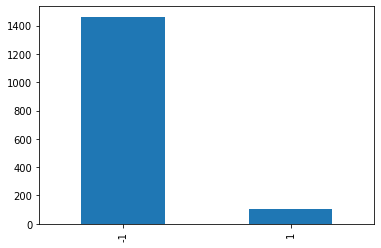

In [15]:
df['classification'].value_counts().plot(kind = 'bar')

### Handle class imbalance problem

#### Define predicators and target

X = All features minus the target, column "classification"

y = classification - simple pass/fail yield for in house line testing

In [16]:
# define X 
X = df.drop('classification', axis=1)

# define y
y = df['classification']

In [17]:
# use SMOTE to resample data from X, y
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({-1: 1463, 1: 1463})


In [18]:
# combine resampled x and y into new dataframe
resampled = pd.DataFrame(X_res, columns=X.columns)

resampled['classification'] = y_res

In [19]:
resampled.head()

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,classification
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,72.2889,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,72.2889,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [20]:
# redefine X 
X = resampled.drop('classification', axis=1)

# redefine y
Y = resampled['classification']

### Split the data into training and testing sets

In [21]:
# split into a training and testing set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

### Build a simple neural networks model

In [22]:
Y1 = Y.to_numpy()

In [23]:
Y1 = Y1.reshape((Y1.shape[0], 1))

In [24]:
# Creating a numerically stable logistic s-shaped definition to call
def sigmoid(x):
    x = np.clip(x, -500, 500)
    if x.any()>=0:
        return 1/(1 + np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

In [25]:
# define the dimentions and set the weights to random numbers
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

In [26]:
# Single layer network: Forward Prop
# Passed in the weight vectors, bias vector, the input vector and the Y
def fwd_prop(W1,bias,X,Y1):

    Z1 = np.dot(W1,X) + bias # dot product of the weights and X + bias
    A1 = sigmoid(Z1)  # Uses sigmoid to create a predicted vector

    return(A1)

In [27]:
#Single layer network: Backprop

def back_prop(A1,W1,bias,X,Y1):

    m = np.shape(X)[1] # used the calculate the cost by the number of inputs -1/m
   
    # Cross entropy loss function
    cost = (-1/m)*np.sum(Y1*np.log(A1) + (1-Y1)*np.log(1-A1)) # cost of error
    dZ1 = A1 - Y1                                            # subtract actual from pred weights
    dW1 = (1/m) * np.dot(dZ1, X.T)                          # calc new weight vector
    dBias = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)  # calc new bias vector
    
    grads ={"dW1": dW1, "dB1":dBias} # Weight and bias vectors after backprop
    
    return(grads,cost)

In [28]:
def run_grad_desc(num_epochs,learning_rate,X,Y1,n_1):
    
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, True)
    B1 = init_parameters(n_1,1, True)
    
    loss_array = np.ones([num_epochs])*np.nan # resets the loss_array to NaNs
    
    for i in np.arange(num_epochs):
        A1 = fwd_prop(W1,B1,X,Y1)                # get predicted vector
        grads,cost = back_prop(A1,W1,B1,X,Y1)    # get gradient and the cost from BP 
        
        W1 = W1 - learning_rate*grads["dW1"]    # update weight vector LR*gradient*[BP weights]
        B1 = B1 - learning_rate*grads["dB1"]    # update bias LR*gradient[BP bias]
        
        loss_array[i] = cost                    # loss array gets cross ent values
        
        parameter = {"W1":W1,"B1":B1}           # assign 
    
    return(parameter,loss_array)

In [29]:
num_epochs = 100
learning_rate = 0.001
params, loss_array = run_grad_desc(num_epochs,learning_rate,X,Y1,n_1= 1 )
print(loss_array[num_epochs-1])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


nan


### Build a DNN model

#### Configure the layers

In [30]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=474))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='softmax'))

#### Compilation - configure the learning process including defining the optimizer, loss function, and metric.

In [31]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train model  with our training data and by defining the number of epochs.

In [32]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
2340/2340 [==============================] - 0s 117us/step - loss: 15.9288 - acc: 0.5004
Epoch 2/10
2340/2340 [==============================] - 0s 47us/step - loss: 15.9288 - acc: 0.5004
Epoch 3/10
2340/2340 [==============================] - 0s 45us/step - loss: 15.9288 - acc: 0.5004
Epoch 4/10
2340/2340 [==============================] - 0s 33us/step - loss: 15.9288 - acc: 0.5004
Epoch 5/10
2340/2340 [==============================] - 0s 34us/step - loss: 15.9288 - acc: 0.5004
Epoch 6/10
2340/2340 [==============================] - 0s 34us/step - loss: 15.9288 - acc: 0.5004
Epoch 7/10
2340/2340 [==============================] - 0s 37us/step - loss: 15.9288 - acc: 0.5004
Epoch 8/10
2340/2340 [==============================] - 0s 49us/step - loss: 15.9288 - acc: 0.5004
Epoch 9/10
2340/2340 [==============================] - 0s 41us/step - loss: 15.9288 - acc: 0.5004
Epoch 10/10
2340/2340 [==============================] - 0s 36us/step - loss: 15.9288 - acc: 0.5004


#### Apply model to test set and evaluate accuracy

In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

586/586 [==============================] - 0s 78us/step
Test accuracy: 0.4982935157652194


### Build a RNN model

In [34]:
df2 = df2.set_index('date')

In [35]:
df2['classification'][:'2008-09-19 15:22:00']

date
2008-07-19 11:55:00   -1
2008-07-19 12:32:00   -1
2008-07-19 13:17:00    1
2008-07-19 14:43:00   -1
2008-07-19 15:22:00   -1
                      ..
2008-09-10 07:38:00   -1
2008-09-10 14:15:00   -1
2008-09-10 15:04:00   -1
2008-09-10 15:55:00    1
2008-09-10 15:56:00   -1
Name: classification, Length: 1079, dtype: int64

In [36]:
training_set = df2[:'2008-09-19 15:22:00'].iloc[:,1:591].values
test_set = df2['2008-09-19 15:22:00':].iloc[:,1:591].values

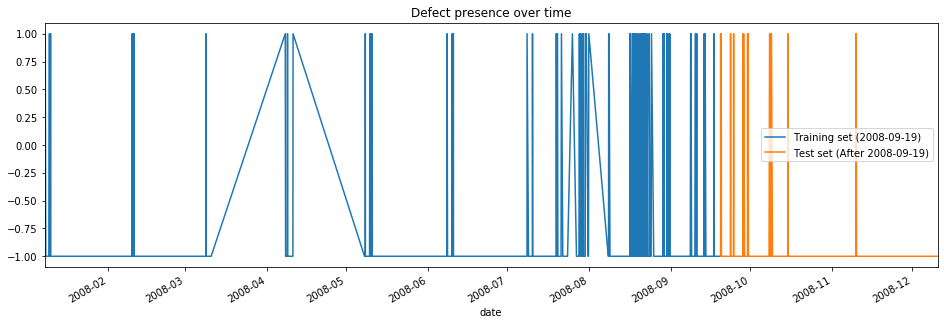

In [37]:
# Review defect presence over time
df2["classification"][:'2008-09-19 15:22:00'].plot(figsize=(16,5),legend=True)
df2["classification"]['2008-09-19 15:22:00':].plot(figsize=(16,5),legend=True)
plt.legend(['Training set (2008-09-19)','Test set (After 2008-09-19)'])
plt.title('Defect presence over time')
plt.show()

In [38]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [39]:
# Since LSTMs store long term memory state, we create a data structure with 10 timesteps and 1 output
# So for each element of training set, we have 10 previous training set elements 
X_train = []
y_train = []
for i in range(10,1079):
    X_train.append(training_set_scaled[i-10:i,0])
    y_train.append(training_set_scaled[i,589])
X_train, y_train = np.array(X_train), np.array(y_train)

In [40]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [41]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
1069/1069 [==============================] - 3s 3ms/step - loss: 0.0738 - acc: 0.9205
Epoch 2/5
1069/1069 [==============================] - 1s 853us/step - loss: 0.0737 - acc: 0.9205
Epoch 3/5
1069/1069 [==============================] - 1s 859us/step - loss: 0.0739 - acc: 0.9205
Epoch 4/5
1069/1069 [==============================] - 1s 875us/step - loss: 0.0738 - acc: 0.9205
Epoch 5/5
1069/1069 [==============================] - 1s 872us/step - loss: 0.0736 - acc: 0.9205


In [42]:
testing_set_scaled = sc.fit_transform(test_set)

In [43]:
len(testing_set_scaled)

488

In [44]:
X_test = []
y_test = []
for i in range(10,488):
    X_test.append(testing_set_scaled[i-10:i,0])
    y_test.append(testing_set_scaled[i,589])
X_test, y_test = np.array(X_test), np.array(y_test)

In [45]:
# Reshaping X_train for efficient modelling
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [46]:
test_loss, test_acc = regressor.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

478/478 [==============================] - 0s 920us/step
Test accuracy: 0.9686192468619247


### Describe Findings

Adding in the date/time column helped produce a more accurate model than the prevous attempts using Simple ANN and DNN. Overall, it was more accurate; however, it's difficult to answer specifically what is causing the defects. The RNN model looks to be much more accurate at predicting when a defect will occur. Visualizing the defect presence graph clearly shows clusters of times that were an issue as opposed to consistent defects. I would like to continue to use the RNN for the future of the manufacturing to simulate future production levels and predict defects.

### Instructions to Solicit Feedback
Write 2-3 questions soliciting feedback on specific aspects on the assignment. For example, if you did something one way but are unsure if there might be a different or better way to do it, ask for feedback on that part. You may submit these questions by commenting out in the code within your .ipynb file or by typing them below your file name in the Your Response box on the Submit Milestone Assignment page. While the questions you submit will have no bearing on your grade, by doing so, you will engage more actively with the assignment and we will also be able to give you pointed feedback.

1. I'ved struggled the simple ANN with this dataset. Adjusting parameters didn't seem to help and adjusting epochs too high or learning rate too low would not converge in a timely manner. Can you advise on how to better use ANN with this dataset?
 

2. The DNN I created stayed at ~50% accuracy when I added additional layers. I tried dropout; however, that reduced the accuracy and slowed the training time. What other changes do you recommend exploring?

3. Given RNNs specialization with temporal data, how else could I have looked at the dataset? Adding date back into the dataset was the only way I saw that RNN could be used for modeling. Do you have other ways I could use RNN for this?